**NOTE** `phimats_rve` environment should be used as kernel

In [1]:
import numpy as np
from datetime import datetime
import h5py

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, cm
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

from importlib import reload

import PHIMATS_RVE
from PHIMATS_RVE import PhaseField
from Initializations import *

In [ ]:
Simul  = 'Two_Phase'           # Simulation name
Nx     = 400               # grid points in x-directoin.
Ny     = 400               # grid points in y-direction.
Nz     = 0
iWidth = 20                # interface width in grid points.
dx     = 0.25e-6           # grid point spacing in (m).
NumberOfGrains = 20        # Number of seeds
dt     = 0.005             # time increment in (s).
nSteps = 1000              # Number of time steps.
sTime  = 100               # Output to disk every tSteps. 

# Mobility Data --------------------
sigma = 1
eee = 3.0e+6

PhaseFieldData = {
    "Simul": Simul,
    "Nx": Nx,
    "Ny": Ny,
    "Nz": Nz,
    "iWidth": iWidth,
    "dx": dx,
    "NumberOfGrains": NumberOfGrains,
    "dt": dt,
    "nSteps": nSteps,
    "sTime": sTime,
    "sigma": sigma,
    "eee": eee,
}

In [9]:
# %matplotlib widget

In [10]:
def CPlot2D(Cx, dpi=100, cmap='RdBu_r'):
                
    fig, ax = plt.subplots(1, 1, figsize=(1*56.25/25.4, 1.5*56.25/25.4), dpi=dpi, tight_layout=True)
    
    c = ax.contourf(Cx, 256, cmap=cmap, vmin=Cx.min(), vmax=Cx.max())
    cbar = fig.colorbar(c, ax=ax, ticks=np.linspace(Cx.min(), Cx.max(), 4), orientation="horizontal", pad=0.05)

    ax.set_aspect('equal', 'box')
    ax.set_xticks([])
    ax.set_yticks([])

In [11]:
reload(PHIMATS_RVE)
from PHIMATS_RVE import PhaseField

In [ ]:
# Create the phase-field object
PF = PhaseField(PhaseFieldData)

# Initialize parent phase
Initializations.Single(PF, 0)

# Initialize parent phase
Initializations.Seeds(PF, NumberOfGrains)

# Calculate interface function gPhi
PF.Calc_gPhi()
# Update grain IDs
PF.UpdateGrain()
PF.getPFID()

# Plot the generated seeds. Make sure they are well separated, otherwise unexpected behavior might result during evolution. 
CPlot2D(PF.gPhi)

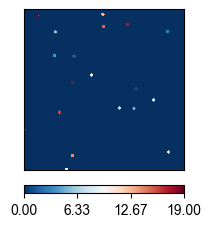

In [19]:
CPlot2D(PF.PhaseFieldID)

In [20]:
# Create hdf5 file to store simulation data and results.
PF.WriteInputData()    

In [ ]:
# Run the phase-field simulation
for iStep in range(1, 30000+1):
    
    # Solve
    PF.UpdateTimeStep()
    
    # Write output results every 500 increments
    if iStep % 500 == 0:

        PF.Calc_gPhi()
        PF.getPFID()
        PF.WriteResults(iStep)
        
        now = datetime.now()
        dt_string = now.strftime("%d-%m-%Y %H:%M:%S")
        print("Write time step:", iStep, "on", dt_string)
        print()

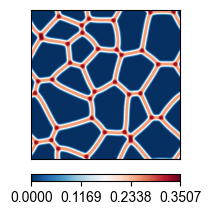

In [22]:
CPlot2D(PF.gPhi)

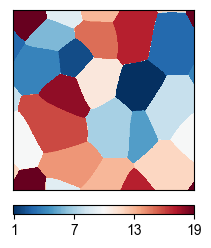

In [23]:
CPlot2D(PF.PhaseFieldID)

### Generate two-phase microstructure 

Two-phase RVEs can be generating by randomly selecting phases up to a predefined area fraction

Effective area fraction of phase phi_j:  0.17313139658690233
Plotting phi_i
Plotting phi_j


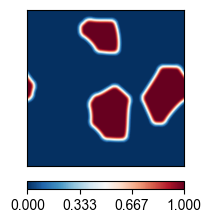

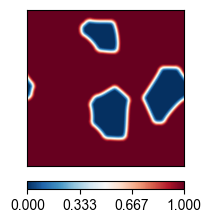

In [ ]:
NGrains, Nx, Ny = PF.PhaseFields.shape

# Array for the secondary phase
phi_j = np.zeros((Nx, Ny))
# Array for the matrix phase
phi_i = np.zeros((Nx, Ny))
# Target area fraction
AreaFac = 0.15

choices = []

for i in range(100):
    
    pick = np.random.choice(range(NumberOfGrains))
    
    if not pick in choices:
        
        choices.append(pick)
        phi_j += PF.PhaseFields[pick]
        
        if phi_j.sum()/(Nx*Ny) >= AreaFac:
            
            for k in range(NGrains): 
                if not k in choices:
                    phi_i += PF.PhaseFields[k]
                
            break

print("Effective area fraction of phase phi_j: ", phi_j.sum()/(Nx*Ny))

print("Plotting phi_i")
CPlot2D(phi_j)

print("Plotting phi_j")
CPlot2D(phi_i)

#### Develop diffuse interfaces for the two-phase RVE

In [36]:
gPhi_ii = np.zeros((Nx,Ny))
gPhi_ij = np.zeros((Nx,Ny))
gPhi_jj = np.zeros((Nx,Ny))

for i in range(NGrains):       
    for j in range(NGrains):
        if i>j:
            if (i in choices) and (j in choices):
                gPhi_jj += PF.PhaseFields[i]*PF.PhaseFields[j]

            if not((i in choices) and (j in choices)):
                if (i in choices) or (j in choices):
                    gPhi_ij += PF.PhaseFields[i]*PF.PhaseFields[j]
                
            if not ((i in choices) or (j in choices)):
                gPhi_ii += PF.PhaseFields[i]*PF.PhaseFields[j]

In [ ]:
# Visualise the new microstructure
CPlot2D(gPhi_ii + 0.1*gPhi_jj + 0.1*phi_j + gPhi_ij, dpi=200, cmap="Spectral_r")

#### Export to hdf5

Export the new order parameters to an RVE 

In [ ]:
with h5py.File("Two_Phase_RVE.hdf5", "w") as fh5:
    fh5.create_dataset("gPhi_ii", data=gPhi_ii, dtype=np.float64)
    fh5.create_dataset("gPhi_ij", data=gPhi_ij, dtype=np.float64)
    fh5.create_dataset("gPhi_jj", data=gPhi_jj, dtype=np.float64)
    fh5.create_dataset("phi_j", data=phi_j, dtype=np.float64)
    fh5.create_dataset("phi_i", data=phi_i, dtype=np.float64)